# Feature Analysis
In this notebook, we will use feature analaysis to study a collection of Shakespeare plays and their genres. We'll examine which word features best characterize each play genre and which feature sets are useful for identifying play genres. Note that this notebook is intended to be a useful reference for your Final Project.

**This notebook will be updated for Thursday's session.**

## Importing Python modules and third-party packages

Import modules and methods. Instead of using hand-crafted clustering methods, we'll be using the implementations provided by [scikit-learn](https://scikit-learn.org/0.23/).

In [1]:
import os
import re
import numpy as np
from collections import Counter
from scipy.stats import entropy

# Modules from scikit-learn
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.naive_bayes import MultinomialNB

# 2D Visualization
from sklearn.decomposition import TruncatedSVD

# Packages for plotting
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.3) # Set the style for the plots

To check the version of an imported package, we can examine the `__version__` attribute. For example, the following cell prints the version of `sklearn` and the version of `numpy` used in this notebook.

In [2]:
import sklearn
print("scikit-learn: {}".format(sklearn.__version__))
print("numpy: {}".format(np.__version__))

scikit-learn: 0.23.2
numpy: 1.19.2


## Loading in & organizing our dataset

For a project, it is extremely useful to consider what data you need and the best forms (i.e. data structures) for this data to take. This might change as your analysis progress, but it's very useful to make these design choices in one central location so that it is easy to reference and update consistently.


In the next two cells, the following useful global variables are defined and constructed:
- `genres`: a list of working play genres
- `all_counts`: a Counter that stores the collection-level counts of each word type
- `doc_counts`: a Counter that stores the *document frequency* of each word type
- `genre_counts`: a dictionary that maps genres to a Counter that stores that genre's word type counts
- `play_data`: a list containing play-level data structures, one per play
- `play_genres`: a list of each play's genre using the same play index as `play_data` 

Each play-level data structure is a *dictionary* with the following fields:
- `"title"`: the play's title
- `"genre"`: the play's genre
- `"counts"`: a Counter that stores the play's word type counts

In [3]:
# Play genres
genres = ['comedy', 'history', 'tragedy']

# This counter will store the total frequency of each word type
all_counts = Counter()
# This counter will store the document frequency of each word type
doc_counts = Counter()
# This counter will store the genre-level counts of each word type
genre_counts = {genre: Counter() for genre in genres}

# A list of play-level data structures, one for each play in the collection
play_data = []
# A list of each play's genre
play_genres = []

In [4]:
# Read in plays from files
word_pattern = re.compile("\w[\w\-\']*\w|\w")
genre_directories = {
    "comedy": "shakespeare/comedies",
    "history": "shakespeare/histories",
    "tragedy": "shakespeare/tragedies",
}

for genre, genre_directory in genre_directories.items():
    for filename in os.listdir(genre_directory):
        # Only read .txt files
        if filename.endswith('.txt'):
            # Initialize play-specific data structures
            play_counter = Counter()
            play_data.append({
                "title": filename[:-4],
                "genre": genre,
                "counts": play_counter,
            })
            play_genres.append(genre)
            
            # Open and tokenize file
            filepath = '{}/{}'.format(genre_directory, filename)
            with open(filepath, encoding='utf-8') as reader: ## What encoding are the files in?
                for line in reader:
                    line = line.strip()
                    # Skip empty and non-speaking lines
                    if line and not line.startswith('<'):
                        line = line.lower()
                        tokens = word_pattern.findall(line)
                        play_counter.update(tokens)
            # Update genre and overall counters
            genre_counts[genre].update(play_counter)
            doc_counts.update(play_counter.keys())
            all_counts += play_counter

## Constructing initial feature set and vectors

For the purposes of this notebook, we'll assume our features correspond to individual words. Our initial feature set `vocabulary` will be all words that occur in two or more plays.

In [5]:
vocabulary = []
for word_type, doc_count in doc_counts.most_common():
    if doc_count > 1:
        vocabulary.append(word_type)

We'll construct our initial play vectors such that each component of a play's vector corresponds to the number of times some term in `vocabulary` occurs in that play. We'll store these vectors within `play_vectors` using the same play indices as `play_data`. Note that each vector is a [numpy array](https://numpy.org/doc/stable/reference/generated/numpy.array.html).

We'll use the function `build_vectors` to do this. This function constructs play count vectors using features specified by the input list `vocab`.   

In [6]:
def build_vectors(vocab):
    vectors = []
    for struct in play_data:
        counts = struct['counts']
        vector = np.array([counts[w] for w in vocab])
        vectors.append(vector)
    return vectors

In [7]:
play_vectors = build_vectors(vocabulary)

## How well do the initial vectors reflect play genre?
### Visualizing Vectors
By examining a two-dimensional projection of our vectors, we can often gain a sense of how well our vectors cluster and if these clusterings correspond to known categorizations.

In [8]:
def plot_plays(vectors):
    svd_model = TruncatedSVD(n_components=2)
    vectors_2d = svd_model.fit_transform(vectors)

    # Plot 2d vectors
    plt.figure(figsize=(6,6))
    _ = sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], hue=play_genres,
                        s=100, alpha=.75)
    _ = plt.legend(loc="center left", bbox_to_anchor=(1.05, .5),borderaxespad=0)
    _ = plt.xticks([])
    _ = plt.yticks([])

Using `plot_plays` we can see that our initial play vectors are somewhat separated by genre.

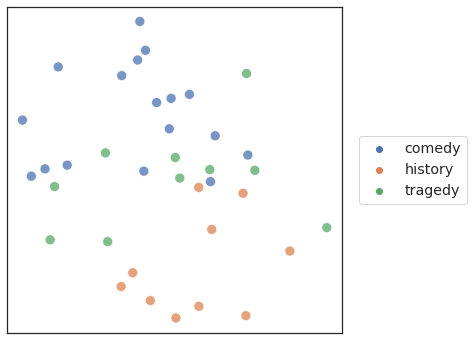

In [9]:
plot_plays(play_vectors)

### Classifying vectors
We can further evaluate the quality of our feature representations (i.e. vectors) by measuring how well they can be used to classify plays be genre.

`classify_plays` trains a Naive Bayes classifier with a default smoothing of 1. For each play, we train a classifier using the vectors of all other plays and then use it to predict the unseen play's genre. This is a form of *cross-validation* called "leave-one-out". It prints the overall accuracy of the classifier, as well as the classifier's genre-level accuracies.

In [10]:
def classify_plays(vectors, smoothing=1):
    model = MultinomialNB(alpha=smoothing, fit_prior=False)
    cross_validator = LeaveOneOut()
    scores = cross_val_score(model, vectors, play_genres, cv=cross_validator)
    # Compute overall accuracy
    print("Overall Accuracy: {:.1f}%\n".format(100*sum(scores)/len(scores)))
    # Compute genre-level acuracies
    genre_scores = {g:[] for g in genres}
    for i, genre in enumerate(play_genres):
        genre_scores[genre].append(scores[i])
    for g in genres:
        genre_name = g.title() + ' ' if g == 'comedy' else g.title()
        print("{} Accuracy: {:.1f}%".format(genre_name,
              100*sum(genre_scores[g])/len(genre_scores[g])))

In [11]:
classify_plays(play_vectors)

Overall Accuracy: 75.7%

Comedy  Accuracy: 76.5%
History Accuracy: 90.0%
Tragedy Accuracy: 60.0%


Q: Given the visualization and classification of our initial vectors, how well do our features capture genre?

We can further examine how well our features can capture *individual* genres using *binary* classification. Instead of directly using our play genre labels for classification. We'll convert them into *binary* labels of the form genre "X" and *not* genre "X".

`classify_genre` will print the results of a binary classification for a given play genre `genre`.

In [12]:
def classify_genre(genre, vectors, smoothing=1):
    # Construct binary labels
    binary_labels = []
    for g in play_genres:
        if g == genre:
            binary_labels.append(g)
        else:
            binary_labels.append("not_{}".format(genre))
    # Train binary classifier
    model = MultinomialNB(alpha=smoothing, fit_prior=False)
    cross_validator = LeaveOneOut()
    scores = cross_val_score(model, vectors, binary_labels, cv=cross_validator)
    # Compute overall accuracy
    print("Accuracy: {:.1f}%".format(100*sum(scores)/len(scores)))

Q: What are the accuracy results for each genre?

| Genre | Classifier Accuracy |
| :- | :-: |
| Comedy | ??.?% |
| History | ??.?% |
| Tragedy | ??.?% |

Q: Why might the binary classifier results differ from the previous *multi-class* (i.e. play genre) classifier? 

## Which features reflect genre?
We can examine the most distinctive words of each genre using *Dunning g-scores*. 

To compute the Dunning g-score for a term *t* and genre *g* we'll first build the following contingency table.

Q: What does each table entry correspond to?

| | *g* | Not *g* |
| :- | :-: | :-: |
| ***t*** | ? | ? |
| **not *t*** | ? | ? | 

`get_contingency_table` will build the needed contingency table for a given term and genre. We can provide this as input to `dunning_gscore` to compute the Dunning g-score for that genre-term pair.

In [13]:
# collection- and genre-level token lengths
collection_length = sum([all_counts[term] for term in vocabulary])
genre_lengths = {genre: sum([genre_counts[genre][term] for term in vocabulary]) for genre in genres}

def get_contingency_table(term, genre):
    table = np.zeros((2,2))
    genre_length = genre_lengths[genre]
    genre_counter = genre_counts[genre]
    table[0, 0] = genre_counter[term]
    table[1, 0] = all_counts[term] - genre_counter[term]
    table[0, 1] = genre_length - genre_counter[term]
    table[1, 1] = (collection_length - genre_length) - (all_counts[term] - genre_counter[term])
    return table

def dunning_gscore(table, signed=False):
    rows = table.sum(axis=1)
    cols = table.sum(axis=0)
    score = 2 * table.sum() * (entropy(rows) + entropy(cols) - entropy(table.flatten()))
    if signed:
        assert(table.shape == (2,2))
        if table[0,0]/table[:, 0].sum() < table[0,1]/table[:, 1].sum() > 0:
            score *= -1
    return score

So, we can compute the Dunning g-score for a given term and genre as follows:

In [14]:
term = 'marry'
genre = 'comedy'
table = get_contingency_table(term, genre)
dunning_gscore(table)

44.790672702440034

Q: What are the top 10 most distinctive words of each genre using Dunning g-scores?

| Most Distinctive | Comedy | Tragedy | History |
| -: | :-: | :-: | :-: |
| 1 | ? | ? | ? |
| 2 | ? | ? | ? |
| 3 | ? | ? | ? |
| 4 | ? | ? | ? |
| 5 | ? | ? | ? |
| 6 | ? | ? | ? |
| 7 | ? | ? | ? |
| 8 | ? | ? | ? |
| 9 | ? | ? | ? |
| 10 | ? | ? | ? |

Unfortunately, these lists will have some overlap since Dunning g-scores indicate the feature's usefulness for distinguishing between a genre and other genres. 
The larger a Dunning g-score is, the more a term can be used to identify a particular genre. However, this corresponds to both words that are *strongly* related to the genre in question and words that are strongly *unrelated* to the genre. We distinguish between these two cases by comparing the proportions of the term occuring in the genre versus in the other genres.

Q: How does `dunning_gscore`'s `signed` option differentiate dunning g-scores that indicate a word is more related or unrelated to the genre of focus?

Q: What are the 10 words that best characterize each genre using Dunning g-scores?

| Most Characteristic | Comedy | Tragedy | History |
| -: | :-: | :-: | :-: |
| 1 | ? | ? | ? |
| 2 | ? | ? | ? |
| 3 | ? | ? | ? |
| 4 | ? | ? | ? |
| 5 | ? | ? | ? |
| 6 | ? | ? | ? |
| 7 | ? | ? | ? |
| 8 | ? | ? | ? |
| 9 | ? | ? | ? |
| 10 | ? | ? | ? |

Q: How might we using Dunning g-scores to improve our vector representations so that they better reflect play genre?